In [1]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys,os
import nengo

sys.path.insert(0,'../networks')
from ldn import LDN

sys.path.insert(0,'../')
from utilities import generate_train_test_split

In [2]:
data_dir = '../fall_detection_data/merged_processed/'
subject_file = 'SA06-merged.csv'

# LDN parameters
size_in = 9         # 9 features of the fall detection data
theta = 1.
q = 42

# simulation parameters
dt = 0.001

# training dataset parameters
train_test_split = 0.5
chunk_size = 3600
scaling_factor = 100

# prediction parameters
decision_threshold = 0.5
test_on_train = False

In [3]:
# load data and generate the train/test split
ddf = pd.read_csv(os.path.join(data_dir,subject_file),index_col=0).drop(['TimeStamp(s)','FrameCounter'],axis=1)

chunk_indices = np.arange(0,ddf.shape[0],chunk_size)
train_chunk_indices = np.random.choice(chunk_indices,size = int(len(chunk_indices)*train_test_split))
test_chunk_indices = list(set(chunk_indices)-set(train_chunk_indices))

train_df = pd.DataFrame(columns=ddf.columns)
for idx in train_chunk_indices:
    train_df = pd.concat([train_df,ddf.iloc[idx:idx+chunk_size,:]],axis=0)

test_df = pd.DataFrame(columns=ddf.columns)
for idx in test_chunk_indices:
    test_df = pd.concat([test_df,ddf.iloc[idx:idx+chunk_size,:]],axis=0)

train_xs = train_df[['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']].to_numpy()
lmu_train_xs = LDN(theta=theta, q=q, size_in=size_in).apply(train_xs)
train_ys = ( train_df[['Fall/No Fall']].to_numpy() * scaling_factor ).astype(int)

if test_on_train == True:
    test_xs = train_xs
    test_ys = train_ys
else:
    test_xs = test_df[['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']].to_numpy()
    test_ys = test_df[['Fall/No Fall']].to_numpy() * scaling_factor


/tmp/ipykernel_84388/3737410898.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv(os.path.join(data_dir,subject_file),index_col=0).drop(['TimeStamp(s)','FrameCounter'],axis=1)


In [4]:
model = nengo.Network()
with model:

    def stim_func(t):
        index = int(t/dt)-1
        return test_xs[index,:]
        
    stim = nengo.Node( size_out = size_in, output = stim_func )
    
    ldn = nengo.Node( LDN( theta = theta, q = q, size_in = size_in))
    nengo.Connection(stim, ldn, synapse=None)
    
    neurons = nengo.Ensemble(n_neurons=1000, dimensions=q*size_in, neuron_type=nengo.LIFRate())
    nengo.Connection(ldn, neurons)
    
    # initialize the network with the training data
    category = nengo.Ensemble(n_neurons=1000,dimensions=1,radius=scaling_factor)
    nengo.Connection(neurons, category, eval_points=lmu_train_xs, function=train_ys)
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_category = nengo.Probe(category, synapse=0.01)

In [5]:
sim = nengo.Simulator(model,dt=dt)
with sim:
    sim.run(test_xs.shape[0]*dt)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

True Negatives: 67194
False Positives: 872
False Negatives: 3862
True Positives: 333
Sensitivity: 7.94%
Specificity: 98.72%


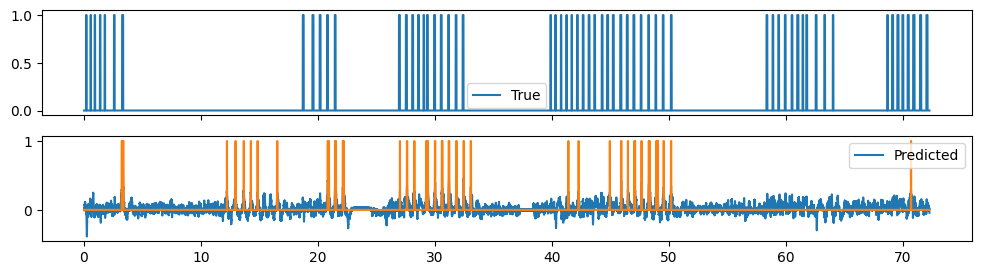

In [6]:
predictions = np.where(sim.data[p_category].flatten() > np.max(sim.data[p_category].flatten())*decision_threshold, 1, 0)    
tn, fp, fn, tp = confusion_matrix( (test_ys/scaling_factor).astype(int), predictions ).ravel()
    
for performance_metric, number in zip(('True Negatives','False Positives','False Negatives','True Positives'),(tn, fp, fn, tp)):
    print('{}: {}'.format(performance_metric,number))
    
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
print('Sensitivity: {}%'.format(round(sensitivity*100,2)))
print('Specificity: {}%'.format(round(specificity*100,2)))
    
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,3))
ax1.plot(sim.trange(), test_ys.flatten()/scaling_factor, label='True')
ax2.plot(sim.trange(), sim.data[p_category]/scaling_factor, label='Predicted')
ax2.plot(sim.trange(), predictions)

ax1.legend()
ax2.legend()
plt.show()    